# **Fine-tuning for Audio Classification with 🤗 Transformers**

This notebook shows how to fine-tune multi-lingual pretrained speech models for Automatic Speech Recognition.

This notebook is built to run on the **Keyword Spotting** subset of the [SUPERB dataset](https://huggingface.co/datasets/superb) with any speech model checkpoint from the [Model Hub](https://huggingface.co/models?pipeline_tag=automatic-speech-recognition&sort=downloads) as long as that model has a version with a Sequence Classification head (e.g. [Wav2Vec2ForSequenceClassification](https://huggingface.co/transformers/model_doc/wav2vec2.html#wav2vec2forsequenceclassification)). 

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly:

In [1]:
model_checkpoint = "facebook/wav2vec2-base"
batch_size = 32

Before we start, let's install both `datasets` and `transformers` from master. Also, we need the `librosa` package to load audio files.

In [2]:
%%capture
# !pip install datasets
# !pip install transformers
! pip install datasets transformers
!pip install librosa

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token



Then you need to install Git-LFS to upload your model checkpoints:

In [4]:
%%capture
!apt install git-lfs

## Fine-tuning a model on an audio classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) acoustic models to a Keyword Spotting task of the [SUPERB Benchmark](https://superbbenchmark.org/)

Keyword Spotting (KS) detects preregistered keywords by classifying utterances into a predefined set of words. SUPERB uses the widely used Speech Commands dataset v1.0 for the task. The dataset consists of ten classes of keywords, a class for silence, and an unknown class to include the false positive. 

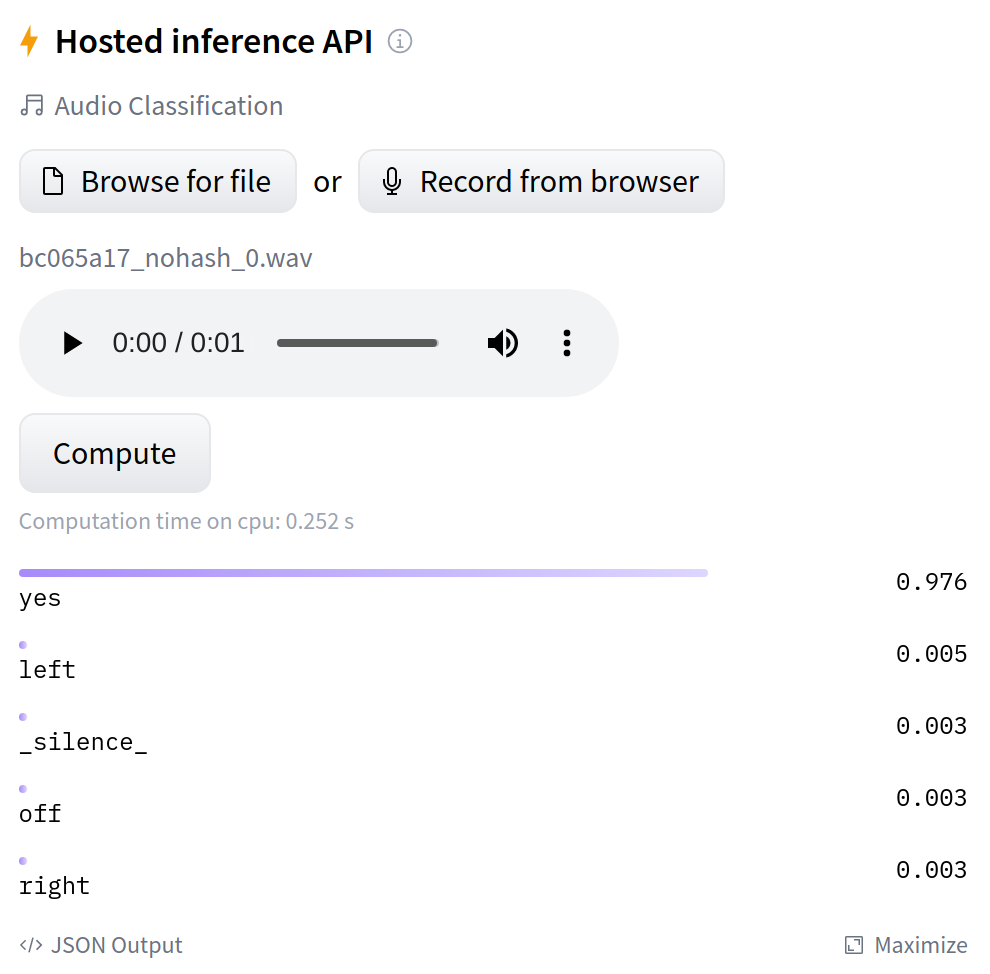

### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the Accuracy metric we need to use for evaluation. This can be easily done with the functions `load_dataset` and `load_metric`.  

In [ ]:
from datasets import load_dataset, load_metric

In [ ]:
dataset = load_dataset("superb", "ks")
metric = load_metric("accuracy")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/51094 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6798 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3081 [00:00<?, ? examples/s]

Dataset superb downloaded and prepared to /root/.cache/huggingface/datasets/superb/ks/1.9.0/b8183f71eabe8c559d7f3f528ab37a6a21ad1ee088fd3423574cecad8b3ec67e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 51094
    })
    validation: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 6798
    })
    test: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 3081
    })
})

To access an actual element, you need to select a split first, then give an index:

In [ ]:
dataset["test"][1000]

{'file': '/root/.cache/huggingface/datasets/downloads/extracted/94c69f12cc18539f842ccec832347d0f85a3424c14bc47bd63902105ba1b2391/go/e41a903b_nohash_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/94c69f12cc18539f842ccec832347d0f85a3424c14bc47bd63902105ba1b2391/go/e41a903b_nohash_4.wav',
  'array': array([-1.2207031e-04,  3.0517578e-05,  1.8310547e-04, ...,
         -4.8828125e-04, -5.4931641e-04, -3.3569336e-04], dtype=float32),
  'sampling_rate': 16000},
 'label': 9}

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [ ]:
dataset["train"].features["label"]

ClassLabel(num_classes=12, names=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', '_silence_', '_unknown_'], id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label["9"]

'go'

`Wav2Vec2` expects the input in the format of a 1-dimensional array of 16 kHz. This means that the audio file has to be loaded and resampled.

 Thankfully, `datasets` does this automatically when calling the column `audio`. Let try it out. 

In [ ]:
dataset["test"][1000]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/94c69f12cc18539f842ccec832347d0f85a3424c14bc47bd63902105ba1b2391/go/e41a903b_nohash_4.wav',
 'array': array([-1.2207031e-04,  3.0517578e-05,  1.8310547e-04, ...,
        -4.8828125e-04, -5.4931641e-04, -3.3569336e-04], dtype=float32),
 'sampling_rate': 16000}

In [ ]:
dataset["test"][1000].keys()

dict_keys(['file', 'audio', 'label'])

We can see that the audio file has automatically been loaded. This is thanks to the new [`"Audio"` feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=audio#datasets.Audio) introduced in `datasets == 1.13.3`, which loads and resamples audio files on-the-fly upon calling.

The sampling rate is set to 16kHz which is what `Wav2Vec2` expects as an input.

To get a sense of what the commands sound like, the following snippet will render 
some audio examples picked randomly from the dataset. 

**Note**: *You can run the following cell a couple of times to listen to different audio samples.*

In [ ]:
import random
from IPython.display import Audio, display

for _ in range(5):
    rand_idx = random.randint(0, len(dataset["train"])-1)
    print("SELECTED INDEX: ", rand_idx)
    example = dataset["train"][rand_idx]
    audio = example["audio"]

    print(f'Label: {id2label[str(example["label"])]}')
    print(f'Shape: {audio["array"].shape}, sampling rate: {audio["sampling_rate"]}')
    display(Audio(audio["array"], rate=audio["sampling_rate"]))
    print()

Label: _unknown_
Shape: (16000,), sampling rate: 16000



Label: down
Shape: (16000,), sampling rate: 16000



Label: _unknown_
Shape: (16000,), sampling rate: 16000



Label: _unknown_
Shape: (14861,), sampling rate: 16000



Label: stop
Shape: (16000,), sampling rate: 16000


If you run the cell a couple of times, you'll see that despite slight variations in length, most of the samples are about 1 second long (`duration = audio_length / sampling_rate`). So we can safely truncate and pad the samples to `16000`.

### Preprocessing the data

Before we can feed those audio clips to our model, we need to preprocess them. This is done by a 🤗 Transformers `FeatureExtractor` which will normalize the inputs and put them in a format the model expects, as well as generate the other inputs that the model requires.

To do all of this, we instantiate our feature extractor with the `AutoFeatureExtractor.from_pretrained` method, which will ensure that we get a preprocessor that corresponds to the model architecture we want to use.

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:370: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

As we've noticed earlier, the samples are roughly 1 second long, so let's set it here:

In [ ]:
max_duration = 1.0  # seconds

We can then write the function that will preprocess our samples. We just feed them to the `feature_extractor` with the argument `truncation=True`, as well as the maximum sample length. This will ensure that very long inputs like the ones in the `_silence_` class can be safely batched.

In [ ]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=int(feature_extractor.sampling_rate * max_duration), 
        truncation=True, 
    )
    return inputs

The feature extractor will return a list of numpy arays for each example:

In [ ]:
preprocess_function(dataset['train'][:5])

{'input_values': [array([-9.1631009e-05, -9.1631009e-05, -9.1631009e-05, ...,
       -4.6719767e-02, -8.0353022e-01, -1.3182331e+00], dtype=float32), array([0.01049979, 0.01049979, 0.01049979, ..., 0.6454253 , 0.43378347,
       0.25741526], dtype=float32), array([ 9.0340059e-04,  9.0340059e-04,  9.0340059e-04, ...,
       -1.7281245e-01,  2.2313449e-01,  1.9931581e+00], dtype=float32), array([ 1.5586768 ,  0.3870289 ,  0.74101615, ..., -0.8897349 ,
       -0.7703889 , -0.09471782], dtype=float32), array([-0.01518929, -0.01518929, -0.01518929, ..., -0.84138   ,
        0.22227868, -0.02409434], dtype=float32)]}

To apply this function on all utterances in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [ ]:
encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio", "file"], batched=True)


  0%|          | 0/52 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 51094
    })
    validation: Dataset({
        features: ['label', 'input_values'],
        num_rows: 6798
    })
    test: Dataset({
        features: ['label', 'input_values'],
        num_rows: 3081
    })
})

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForAudioClassification` class. Like with the feature extractor, the `from_pretrained` method will download and cache the model for us. As the label ids and the number of labels are dataset dependent, we pass `num_labels`, `label2id`, and `id2label` alongside the `model_checkpoint` here:

In [ ]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint, 
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:370: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['quantizer.weight_proj.weight', 'quantizer.codevectors', 'project_q.weight', 'project_q.bias', 'project_hid.bias', 'quantizer.weight_proj.bias', 'project_hid.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.weight', 'projector.weight', 'projecto

The warning is telling us we are throwing away some weights (the `quantizer` and `project_q` layers) and randomly initializing some other (the `projector` and `classifier` layers). This is expected in this case, because we are removing the head used to pretrain the model on an unsupervised Vector Quantization objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-ks",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"anton-l/wav2vec2-finetuned-ks"` or `"huggingface/anton-l/wav2vec2-finetuned-ks"`).

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/Shebna/wav2vec2-base-finetuned-ks into local empty directory.


You might wonder why we pass along the `feature_extractor` as a tokenizer when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `feature_extractor` has a pad method that will do all of this for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

Now we can finetune our model by calling the `train` method:

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 51094
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1995


Epoch,Training Loss,Validation Loss,Accuracy
0,0.665800,0.541979,0.959988
1,0.293900,0.170146,0.977788
2,0.185100,0.106523,0.980877
3,0.167600,0.088332,0.983819
4,0.119100,0.083288,0.983230


***** Running Evaluation *****
  Num examples = 6798
  Batch size = 32
Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-399
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-399/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-399/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-399/preprocessor_config.json
Feature extractor saved in wav2vec2-base-finetuned-ks/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 6798
  Batch size = 32
Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-798
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-798/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-798/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-798/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 6798
  Batch size = 32
Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoi

TrainOutput(global_step=1995, training_loss=0.46427848348043915, metrics={'train_runtime': 7242.3473, 'train_samples_per_second': 35.274, 'train_steps_per_second': 0.275, 'total_flos': 2.31918157475328e+18, 'train_loss': 0.46427848348043915, 'epoch': 5.0})

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 6798
  Batch size = 32


{'eval_loss': 0.08833246678113937,
 'eval_accuracy': 0.9838187702265372,
 'eval_runtime': 76.5912,
 'eval_samples_per_second': 88.757,
 'eval_steps_per_second': 2.781,
 'epoch': 5.0}

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to wav2vec2-base-finetuned-ks
Configuration saved in wav2vec2-base-finetuned-ks/config.json
Model weights saved in wav2vec2-base-finetuned-ks/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/361M [00:00<?, ?B/s]

Upload file runs/Oct13_06-34-51_12d72f240396/events.out.tfevents.1665652916.12d72f240396.68.2: 100%|##########…

Upload file runs/Oct13_06-34-51_12d72f240396/events.out.tfevents.1665642903.12d72f240396.68.0:   9%|8         …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Shebna/wav2vec2-base-finetuned-ks
   63ed22f..25f034c  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Shebna/wav2vec2-base-finetuned-ks
   63ed22f..25f034c  main -> main

Dropping the following result as it does not have all the necessary fields:
{'dataset': {'name': 'superb', 'type': 'superb', 'config': 'ks', 'split': 'train', 'args': 'ks'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.9838187702265372}]}
To https://huggingface.co/Shebna/wav2vec2-base-finetuned-ks
   25f034c..f8ff524  main -> main

   25f034c..f8ff524  main -> main



'https://huggingface.co/Shebna/wav2vec2-base-finetuned-ks/commit/25f034c0c1d6cb5289806c07eacfd43acef41898'

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("anton-l/my-awesome-model")
model = AutoModelForAudioClassification.from_pretrained("anton-l/my-awesome-model")

```

In [5]:
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("Shebna/wav2vec2-base-finetuned-ks")
model = AutoModelForAudioClassification.from_pretrained("Shebna/wav2vec2-base-finetuned-ks")

Downloading:   0%|          | 0.00/215 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/378M [00:00<?, ?B/s]

# BONUS:
Use another audio classification dataset to perform fine-tuning

In [5]:
from datasets import load_dataset, load_metric

In [6]:
model_checkpoint = "facebook/wav2vec2-base"
batch_size = 32

In [7]:
dataset = load_dataset("PolyAI/minds14", name="en-US")
metric = load_metric("accuracy")

Generating train split: 0 examples [00:00, ? examples/s]

Dataset minds14 downloaded and prepared to /root/.cache/huggingface/datasets/PolyAI___minds14/en-US/1.0.0/aa40414f15e0f919231d617440192034af844835dc1e6a697f4b552e0551fd26. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 563
    })
})

In [9]:
dataset_split = dataset['train'].train_test_split(test_size=0.2)

In [10]:
dataset_split

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 450
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 113
    })
})

In [11]:
labels = dataset_split["train"].features["intent_class"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label["9"]

'freeze'

In [12]:
dataset_split["test"][100]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/f14948e0e84be638dd7943ac36518a4cf3324e8b7aa331c5ab11541518e9368c/en-US~ATM_LIMIT/602ba91b05f96973d6794497.wav',
 'array': array([ 0.00024414, -0.00024414,  0.        , ...,  0.        ,
         0.        ,  0.        ], dtype=float32),
 'sampling_rate': 8000}

In [13]:
import random
from IPython.display import Audio, display

for _ in range(5):
    rand_idx = random.randint(0, len(dataset_split["train"])-1)
    print("SELECTED INDEX: ", rand_idx)
    example = dataset_split["train"][rand_idx]
    audio = example["audio"]

    print(f'Label: {id2label[str(example["intent_class"])]}')
    print(f'Shape: {audio["array"].shape}, sampling rate: {audio["sampling_rate"]}')
    display(Audio(audio["array"], rate=audio["sampling_rate"]))
    print()

SELECTED INDEX:  158
Label: card_issues
Shape: (44373,), sampling rate: 8000



SELECTED INDEX:  194
Label: balance
Shape: (47787,), sampling rate: 8000



SELECTED INDEX:  190
Label: atm_limit
Shape: (52565,), sampling rate: 8000



SELECTED INDEX:  65
Label: freeze
Shape: (25941,), sampling rate: 8000



SELECTED INDEX:  378
Label: cash_deposit
Shape: (50517,), sampling rate: 8000


In [14]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:370: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [15]:
dataset_split = dataset_split.remove_columns(["path", "transcription", "english_transcription", "lang_id"])

In [16]:
from datasets import load_dataset, Audio
dataset_split = dataset_split.cast_column("audio", Audio(sampling_rate=16000))

In [17]:
max_duration = 1.0  # seconds

In [18]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=int(feature_extractor.sampling_rate * max_duration), 
        truncation=True, 
    )
    return inputs

In [26]:
encoded_dataset = dataset_split.map(preprocess_function, batched=True)


In [27]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'intent_class', 'input_values'],
        num_rows: 450
    })
    test: Dataset({
        features: ['audio', 'intent_class', 'input_values'],
        num_rows: 113
    })
})

In [28]:
encoded_dataset = encoded_dataset.rename_column("intent_class", "label")

In [29]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint, 
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--wav2vec2-base/snapshots/0b5b8e868dd84f03fd87d01f9c4ff0f080fecfe8/config.json
/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:370: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Model config Wav2Vec2Config {
  "_name_or_path": "facebook/wav2vec2-base",
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForPreTraining"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codeve

In [30]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-ks",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,

)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [31]:
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [32]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

/content/wav2vec2-base-finetuned-ks is already a clone of https://huggingface.co/Shebna/wav2vec2-base-finetuned-ks. Make sure you pull the latest changes with `repo.git_pull()`.


In [33]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: audio. If audio are not expected by `Wav2Vec2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 450
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 15


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,2.637357,0.061947
1,No log,2.643349,0.061947
2,No log,2.650828,0.053097
3,3.225800,2.653958,0.053097
4,3.225800,2.659174,0.044248


The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: audio. If audio are not expected by `Wav2Vec2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 113
  Batch size = 32
Saving model checkpoint to wav2vec2-base-finetuned-ks/checkpoint-3
Configuration saved in wav2vec2-base-finetuned-ks/checkpoint-3/config.json
Model weights saved in wav2vec2-base-finetuned-ks/checkpoint-3/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/checkpoint-3/preprocessor_config.json
Feature extractor saved in wav2vec2-base-finetuned-ks/preprocessor_config.json
The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: audio. If audio are not expected by `Wav2Vec2ForSequenceClassification.forward`,  you can safely ignore this message.


TrainOutput(global_step=15, training_loss=3.155564244588216, metrics={'train_runtime': 100.6863, 'train_samples_per_second': 22.347, 'train_steps_per_second': 0.149, 'total_flos': 1.9828380289536e+16, 'train_loss': 3.155564244588216, 'epoch': 4.8})

In [34]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: audio. If audio are not expected by `Wav2Vec2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 113
  Batch size = 32


{'eval_loss': 2.637357473373413,
 'eval_accuracy': 0.061946902654867256,
 'eval_runtime': 1.3407,
 'eval_samples_per_second': 84.285,
 'eval_steps_per_second': 2.984,
 'epoch': 4.8}

In [35]:
trainer.push_to_hub()

Saving model checkpoint to wav2vec2-base-finetuned-ks
Configuration saved in wav2vec2-base-finetuned-ks/config.json
Model weights saved in wav2vec2-base-finetuned-ks/pytorch_model.bin
Feature extractor saved in wav2vec2-base-finetuned-ks/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/361M [00:00<?, ?B/s]

Upload file runs/Oct13_17-31-09_7b56909b48a3/events.out.tfevents.1665682386.7b56909b48a3.67.4: 100%|##########…

Upload file runs/Oct13_17-31-09_7b56909b48a3/events.out.tfevents.1665682276.7b56909b48a3.67.2:  42%|####1     …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Shebna/wav2vec2-base-finetuned-ks
   f8ff524..598d836  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Shebna/wav2vec2-base-finetuned-ks
   f8ff524..598d836  main -> main

Dropping the following result as it does not have all the necessary fields:
{'dataset': {'name': 'minds14', 'type': 'minds14', 'config': 'en-US', 'split': 'train', 'args': 'en-US'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.061946902654867256}]}
To https://huggingface.co/Shebna/wav2vec2-base-finetuned-ks
   598d836..ac14eca  main -> main

   598d836..ac14eca  main -> main



'https://huggingface.co/Shebna/wav2vec2-base-finetuned-ks/commit/598d8363259ad00223e3bb28931071b0b865940b'